In [72]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [73]:
#read all words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [74]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [75]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one? 

def build_dataset(words):
    X, Y = [], []

    for w in words: 
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [76]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.000001
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.zeros(vocab_size)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
""" bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden)) """

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    # each parameter requires gradient

12297


In [77]:
( torch.randn(1000) * 0.2).std()

(5/3) / (30 ** 0.5)

0.3042903097250923

In [78]:
max_steps = 2000
batch_size = 32
lossi = []
epsilon = 1e-6  # Small value to avoid division by zero

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # normalize/standardize the hidden layer pre-activation
    hpreact_mean = hpreact.mean(0, keepdim=True)
    hpreact_std = hpreact.std(0, keepdim=True) + epsilon
    hpreact = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer

    # loss function
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    # zero out the gradients
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/   2000: 3.2955


(array([159., 191., 221., 162., 169., 157., 153., 143., 129., 143., 136.,
        109., 114., 125., 118., 115., 104., 104., 107.,  96., 116.,  90.,
        100., 102., 107.,  90.,  88., 111.,  97.,  79.,  90.,  98., 112.,
        103., 121.,  93., 122.,  89., 124., 129., 134., 136., 158., 126.,
        152., 151., 182., 197., 199., 149.]),
 array([-0.99564099, -0.95576469, -0.91588838, -0.87601207, -0.83613576,
        -0.79625946, -0.75638315, -0.71650684, -0.67663054, -0.63675423,
        -0.59687792, -0.55700161, -0.51712531, -0.477249  , -0.43737269,
        -0.39749638, -0.35762008, -0.31774377, -0.27786746, -0.23799116,
        -0.19811485, -0.15823854, -0.11836223, -0.07848593, -0.03860962,
         0.00126669,  0.041143  ,  0.0810193 ,  0.12089561,  0.16077192,
         0.20064822,  0.24052453,  0.28040084,  0.32027715,  0.36015345,
         0.40002976,  0.43990607,  0.47978238,  0.51965868,  0.55953499,
         0.5994113 ,  0.6392876 ,  0.67916391,  0.71904022,  0.75891653,
 

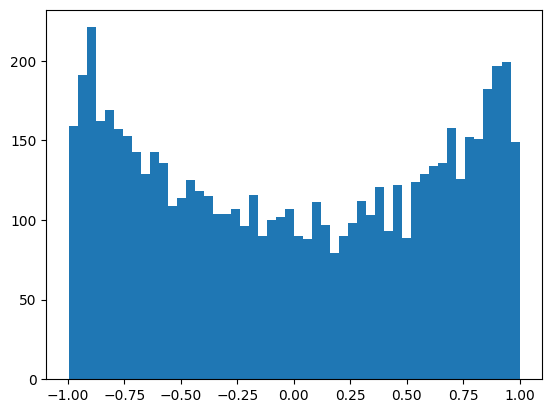

In [79]:
plt.hist( h.view(-1).tolist(), 50)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-3.06323719, -2.93199178, -2.80074636, -2.66950095, -2.53825554,
        -2.40701013, -2.27576471, -2.1445193 , -2.01327389, -1.88202847,
        -1.75078306, -1.61953765, -1.48829224, -1.35704682, -1.22580141,
        -1.094556  , -0.96331059, -0.83206517, -0.70081976, -0.56957435,
        -0.43832893, -0.30708352, -0.17583811, -0.0445927 ,  0.08665272,
         0.21789813,  0.34914354,  0.48038896,  0.61163437,  0.74287978,
         0.87412519,  1.00537061,  1.13661602,  1.26786143,  1.39910685,
         1.53035226,  1.66159767,  1.79284308,  1.9240885 ,  2.05533391,
         2.18657932,  2.31782474,  2.44907015,  2.58031556,  2.71156097,
         2.84280639,  2.9740518 ,  3.10529721,  3.23654263,  3.36778804,
         3.49903345])

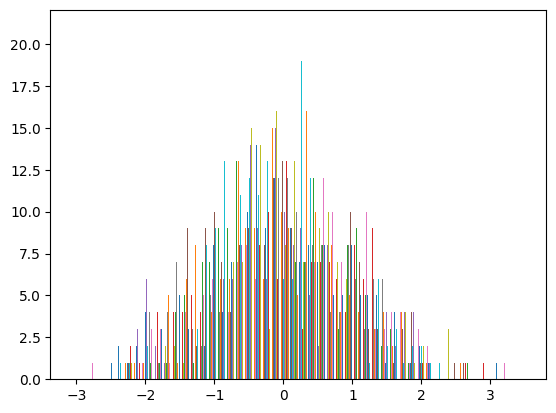

In [80]:
plt.hist( hpreact.tolist(), 50)

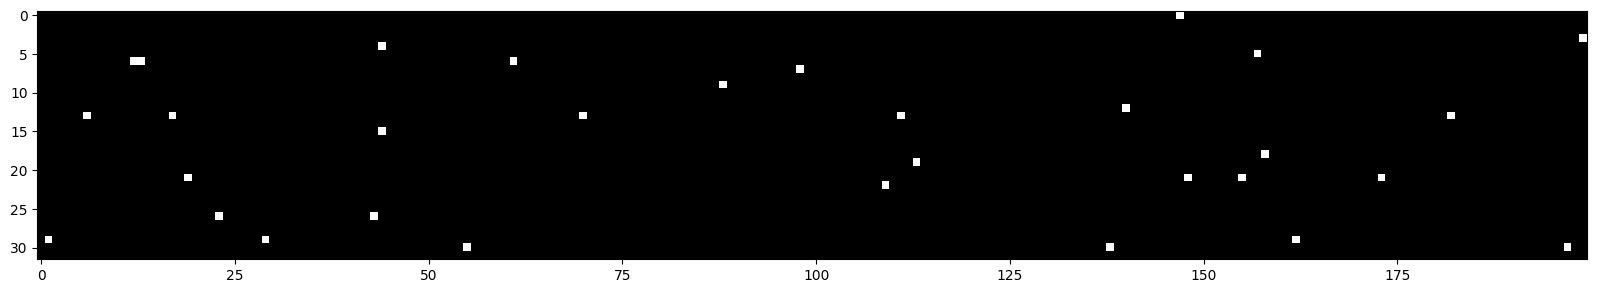

In [81]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

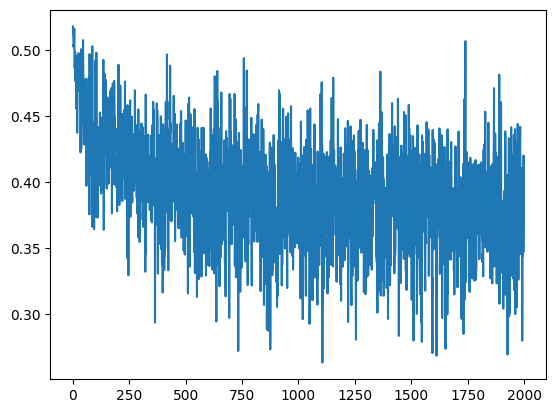

In [82]:
plt.plot(lossi)

In [83]:
# calibrate the bath normalization statistics

with torch.no_grad(): # this decorator disables gradient computation
    # pass the training set through
    emb = C[Xtr] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # normalize/standardize the hidden layer pre-activation
    all_mean = hpreact.mean(0, keepdim = True)
    all_std = hpreact.std(0, keepdim = True)

In [84]:
@torch.no_grad() # this decorator disables gradient computation
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # normalize/standardize the hidden layer pre-activation
    hpreact = bngain * (hpreact - all_mean) / all_std + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


In [85]:
split_loss('train')
split_loss('val')
split_loss('test')

train 2.3629024028778076
val 2.3649046421051025
test 2.363079786300659


In [86]:
# sample fron the model
@torch.no_grad()  # Disables gradient computation
def sample_from_model():
    epsilon = 1e-6  # Small value to avoid division by zero
    for _ in range(20):

        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context])] # (1,block_size,d)
            embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
            hpreact = embcat @ W1 + b1 # hidden layer pre-activation
            # normalize/standardize the hidden layer pre-activation
            hpreact_mean = hpreact.mean(0, keepdim=True)
            hpreact_std = hpreact.std(0, keepdim=True) + epsilon
            hpreact_std = torch.where(hpreact_std < epsilon, torch.tensor(epsilon), hpreact_std)
            hpreact = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias
            h = torch.tanh(hpreact)
            
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)
            # if we sample the special '.' token, break
            if ix == 0:
                break
            
        print(''.join(itos[i] for i in out)) # decode and print the generated word

sample_from_model()

/var/folders/pl/xc3csqh52jq8qrhrzd63c2bm0000gn/T/ipykernel_19079/3615163823.py:16: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  hpreact_std = hpreact.std(0, keepdim=True) + epsilon


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0